In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# dataframe creation functions

def load_participant_data(participant_id, data_dir):
    """
    Load and clean all feature CSV files for a given participant.

    Parameters:
        participant_id (str): Participant folder name (e.g., "001").
        data_dir (str): Path to the root dataset directory.

    Returns:
        dict: Dictionary containing cleaned DataFrames for each feature.
    """
    participant_path = os.path.join(data_dir, participant_id)
    features = ["ACC", "BVP", "Dexcom", "EDA", "HR", "IBI", "TEMP"]
    
    data = {}
    for feature in features:
        file_path = os.path.join(participant_path, f"{feature}.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            
            # Clean column names (strip spaces and lowercase)
            df.columns = df.columns.str.strip().str.lower()
            
            # Standardize timestamp column name
            if "datetime" in df.columns:
                df.rename(columns={"datetime": "timestamp"}, inplace=True)
            elif "timestamp (yyyy-mm-ddthh:mm:ss)" in df.columns:
                df.rename(columns={"timestamp (yyyy-mm-ddthh:mm:ss)": "timestamp"}, inplace=True)
            
            # Extract relevant columns for each feature
            if feature == "Dexcom":
                # Keep only glucose value and timestamp
                df = df[["timestamp", "glucose value (mg/dl)"]]
                df.rename(columns={"glucose value (mg/dl)": "glucose"}, inplace=True)
            elif feature in ["ACC"]:
                # Keep timestamp and accelerometer columns
                df = df[["timestamp", "acc_x", "acc_y", "acc_z"]]
            elif feature in ["BVP", "EDA", "HR", "IBI", "TEMP"]:
                # Keep timestamp and value column
                df = df[["timestamp", feature.lower()]]
            
            # Append to data dictionary
            data[feature] = df
        else:
            print(f"File not found: {file_path}")
    
    return data
def combine_features(data):
    """
    Combine features into a single DataFrame by aligning on timestamps.

    Parameters:
        data (dict): Dictionary of cleaned DataFrames for each feature.

    Returns:
        pd.DataFrame: Merged DataFrame of all features.
    """
    # Start with the Dexcom data (glucose concentration)
    if "Dexcom" not in data or data["Dexcom"] is None:
        raise ValueError("Dexcom data is missing, cannot proceed with combination.")
    
    combined = data["Dexcom"].copy()

    # Ensure 'timestamp' is in datetime format
    if "timestamp" in combined.columns:
        combined["timestamp"] = pd.to_datetime(combined["timestamp"])
    else:
        raise ValueError("Dexcom data must have a 'timestamp' column.")
    
    # Drop missing timestamps from the combined DataFrame
    combined = combined.dropna(subset=["timestamp"])

    # Debugging: Check for missing timestamps
    print("Missing timestamps in 'combined':")
    print(combined[combined["timestamp"].isna()])

    # Iterate through other features
    for feature, df in data.items():
        if feature == "Dexcom" or df is None:
            continue  # Skip Dexcom or missing features

        # Ensure 'timestamp' column exists
        if "timestamp" not in df.columns:
            print(f"Skipping {feature}: 'timestamp' column is missing.")
            continue

        # Ensure 'timestamp' is in datetime format
        df["timestamp"] = pd.to_datetime(df["timestamp"])

        # Drop missing timestamps from the feature DataFrame
        df = df.dropna(subset=["timestamp"])

        # Debugging: Check dtype and missing timestamps
        print(f"Processing {feature}...")
        print(f"Timestamp dtype: {df['timestamp'].dtype}")
        print(f"Missing timestamps in {feature}: {df['timestamp'].isna().sum()} rows")

        # Merge the feature with the combined DataFrame
        combined = pd.merge_asof(
            combined.sort_values("timestamp"),
            df.sort_values("timestamp"),
            on="timestamp",
            direction="nearest"
        )

    return combined

def load_all_participants(data_dir):
    """
    Load and combine data for all participants.

    Parameters:
        data_dir (str): Path to the root dataset directory.

    Returns:
        pd.DataFrame: Concatenated DataFrame of all participants.
    """
    participant_ids = [f"{i:03d}" for i in range(1, 10)]  # Participant folders: 001 to 016
    combined_data = []
    
    for participant_id in participant_ids:
        print(f"Processing participant: {participant_id}")
        participant_data = load_participant_data(participant_id, data_dir)
        combined = combine_features(participant_data)
        combined["participant_id"] = participant_id  # Add participant ID column
        combined_data.append(combined)
    
    return pd.concat(combined_data, ignore_index=True)
def load_demographics(data_dir):
    """
    Load demographic data and return as a DataFrame.
    """
    demographics_path = os.path.join(data_dir, "Demographics.csv")
    demographics = pd.read_csv(demographics_path)
    return demographics

In [5]:
#create dataframe
data_dir = "/Volumes/University_work/physionet.org/files/big-ideas-glycemic-wearable/1.1.2"

demographics = load_demographics(data_dir)

final_data = load_all_participants(data_dir)

Processing participant: 001
Missing timestamps in 'combined':
Empty DataFrame
Columns: [timestamp, glucose]
Index: []
Processing ACC...
Timestamp dtype: datetime64[ns]
Missing timestamps in ACC: 0 rows
Processing BVP...
Timestamp dtype: datetime64[ns]
Missing timestamps in BVP: 0 rows
Processing EDA...
Timestamp dtype: datetime64[ns]
Missing timestamps in EDA: 0 rows


/var/folders/kt/1wn4vm192z12kyhzl90b24_m0000gn/T/ipykernel_11306/2243780650.py:90: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["timestamp"] = pd.to_datetime(df["timestamp"])


Processing HR...
Timestamp dtype: datetime64[ns]
Missing timestamps in HR: 0 rows
Processing IBI...
Timestamp dtype: datetime64[ns]
Missing timestamps in IBI: 0 rows
Processing TEMP...
Timestamp dtype: datetime64[ns]
Missing timestamps in TEMP: 0 rows
Processing participant: 002
Missing timestamps in 'combined':
Empty DataFrame
Columns: [timestamp, glucose]
Index: []
Processing ACC...
Timestamp dtype: datetime64[ns]
Missing timestamps in ACC: 0 rows
Processing BVP...
Timestamp dtype: datetime64[ns]
Missing timestamps in BVP: 0 rows
Processing EDA...
Timestamp dtype: datetime64[ns]
Missing timestamps in EDA: 0 rows
Processing HR...
Timestamp dtype: datetime64[ns]
Missing timestamps in HR: 0 rows
Processing IBI...
Timestamp dtype: datetime64[ns]
Missing timestamps in IBI: 0 rows
Processing TEMP...
Timestamp dtype: datetime64[ns]
Missing timestamps in TEMP: 0 rows
Processing participant: 003
Missing timestamps in 'combined':
Empty DataFrame
Columns: [timestamp, glucose]
Index: []
Processi

In [6]:
#First data segment
#print(final_data.info())

# Show first few rows
#print("\nFirst 5 Rows:")
print(final_data.head())

            timestamp  glucose  acc_x  acc_y  acc_z   bvp       eda     hr  \
0 2020-02-13 17:23:32     61.0   -3.0   48.0   44.0  0.73  0.184489  72.48   
1 2020-02-13 17:28:32     59.0   -7.0   45.0   34.0 -2.46  1.213610  84.18   
2 2020-02-13 17:33:32     58.0    3.0   60.0   44.0  1.06  0.375652  78.23   
3 2020-02-13 17:38:32     59.0   57.0   -1.0  -33.0 -0.08  1.519911  86.40   
4 2020-02-13 17:43:31     63.0   34.0   44.0  -28.0 -1.37  2.096640  76.32   

        ibi   temp participant_id  
0  0.765660  33.63            001  
1  0.640654  32.95            001  
2  0.890666  33.37            001  
3  0.750034  33.29            001  
4  0.609403  33.39            001  


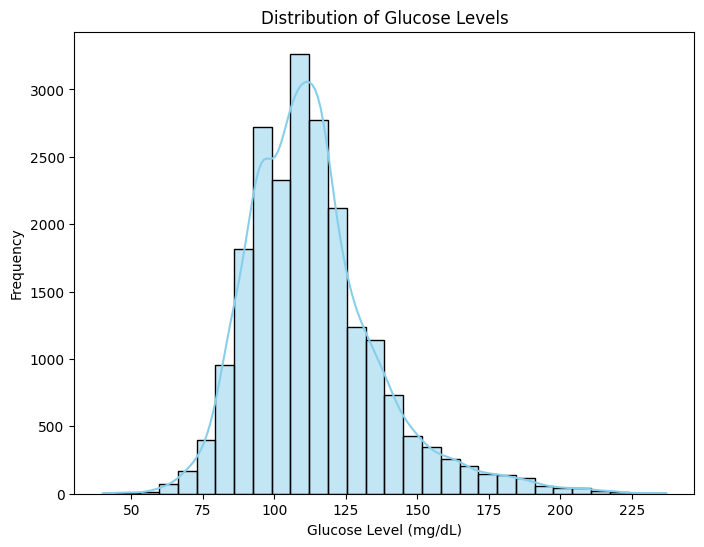

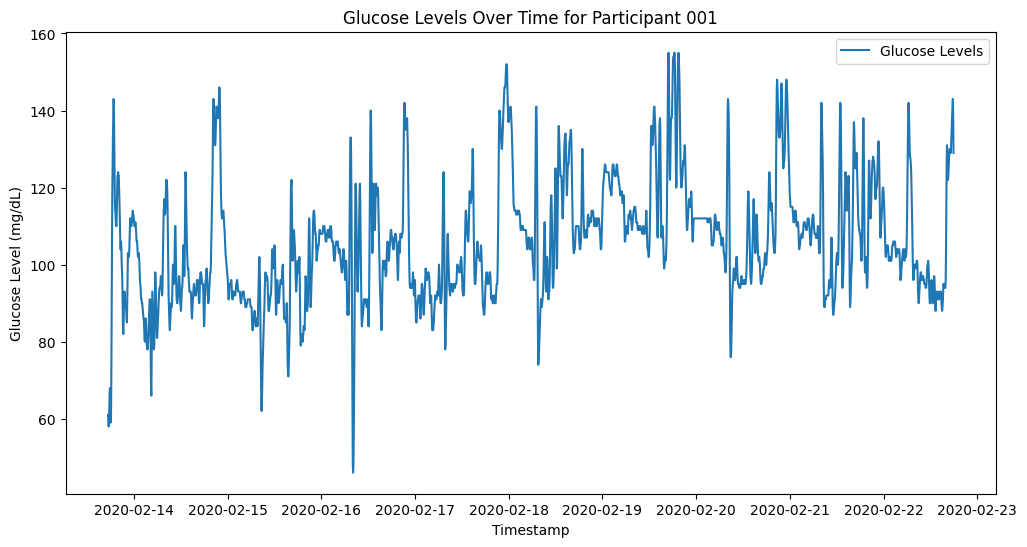

In [7]:
# dataframe plot
plt.figure(figsize=(8, 6))
sns.histplot(final_data["glucose"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Glucose Levels")
plt.xlabel("Glucose Level (mg/dL)")
plt.ylabel("Frequency")
plt.show()

# Time-series for a single participant
participant_id = "001"
participant_data = final_data[final_data["participant_id"] == participant_id]

plt.figure(figsize=(12, 6))
plt.plot(participant_data["timestamp"], participant_data["glucose"], label="Glucose Levels")
plt.title(f"Glucose Levels Over Time for Participant {participant_id}")
plt.xlabel("Timestamp")
plt.ylabel("Glucose Level (mg/dL)")
plt.legend()
plt.show()

In [225]:
def preprocess_glucose(data):
    hourly_data = (
        data
        .set_index("timestamp")  # Set timestamp as index
        .groupby("participant_id")["glucose"]
        .resample("1h")  # Resample to hourly intervals
        .agg(["mean", "std"])  # Calculate mean and std for each hour
        .reset_index()
    )

    # Calculate CV
    hourly_data["cv"] = (hourly_data["std"] / hourly_data["mean"]) * 100
    hourly_data["cv"] = hourly_data["cv"].fillna(0)  # Replace NaN CV with 0 for stability
    #print(hourly_data.columns)
    #return hourly_data
    #print(data.columns)
    
    data = data.sort_values("timestamp")
    hourly_data = hourly_data.sort_values("timestamp")

    #hourly_data = pd.merge_asof(
    #    data.sort_values("timestamp"),
    #    hourly_data.sort_values("timestamp"),
    #    on="timestamp",                     # Merge on timestamp
    #    by="participant_id",                # Match by participant ID
    #    direction="nearest"  
    #)
    return hourly_data

In [18]:
def define_high_gv_cv(hourly_data, cv_threshold=33):
    """
    Define high glycemic variability based on standard deviation threshold.

    Parameters:
        hourly_data (pd.DataFrame): Hourly glucose data with standard deviation.
        threshold (float): Threshold for high GV (default is 30 mg/dL).

    Returns:
        pd.DataFrame: Hourly data with a 'high_gv' column.
    """
    hourly_data["high_gv"] = hourly_data["cv"] > cv_threshold    
    return hourly_data

In [160]:
def plot_glucose_variability(hourly_data, participant_id):
    """
    Plot glucose levels and highlight high-GV periods for a specific participant.
    
    Parameters:
        hourly_data (pd.DataFrame): Hourly glucose data with CV and high GV labels.
        participant_id (str): ID of the participant to plot.
    """
    participant_data = hourly_data[hourly_data["participant_id"] == participant_id]

    plt.figure(figsize=(12, 6))
    plt.plot(participant_data["timestamp"], participant_data["mean"], label="Mean Glucose", color="blue")
    plt.fill_between(
        participant_data["timestamp"],
        participant_data["mean"],
        where=participant_data["high_gv"],
        color="red",
        alpha=0.3,
        label="High GV (CV > 33%)"
    )
    plt.title(f"Hourly Glucose Levels for Participant {participant_id}")
    plt.xlabel("Timestamp")
    plt.ylabel("Glucose (mg/dL)")
    plt.legend()
    plt.show()


In [20]:
def plot_cv_distribution(hourly_data):
    """
    Plot the distribution of CV values across participants.
    
    Parameters:
        hourly_data (pd.DataFrame): Hourly glucose data with CV values.
    """
    plt.figure(figsize=(8, 6))
    sns.histplot(hourly_data["cv"], bins=20, kde=True, color="skyblue")
    plt.axvline(33, color="red", linestyle="--", label="High GV Threshold (CV > 33%)")
    plt.title("Distribution of Coefficient of Variation (CV)")
    plt.xlabel("CV (%)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [203]:
def resample_to_hourly(data):
    """
    Resample the dataset to hourly intervals, aggregating numeric features.

    Parameters:
        data (pd.DataFrame): Input dataset with timestamps and wearable features.

    Returns:
        pd.DataFrame: Hourly resampled dataset with aggregated statistics.
    """
    # Ensure timestamps are in datetime format
    data["timestamp"] = pd.to_datetime(data["timestamp"])

    # Set timestamp as the index
    data.set_index("timestamp", inplace=True)

    # Group by participant_id and resample to hourly intervals
    hourly_data = (
        data.groupby("participant_id")
        .resample("1H")
        .agg({
            "glucose": "mean",
            "acc_x": "mean",
            "acc_y": "mean",
            "acc_z": "mean",
            "bvp": "mean",
            "eda": "mean",
            "hr": "mean",
            "ibi": "mean",
            "temp": "mean",
            "mean": "mean",
            "std": "mean",
            "cv": "mean",
            "high_gv": "max",  # Use max for binary columns
        })
        .reset_index()  # Reset the index to include timestamp as a column
    )

    return hourly_data

In [2]:
# create hourly dataframe and figure out high glucose variability
hourly_data = preprocess_glucose(final_data)
dataa = final_data.sort_values(by=["participant_id", "timestamp"])
# print(hourly_data.columns)
#print(dataa.head())
hourly_data = define_high_gv_cv(hourly_data, cv_threshold=33)

#final_hourly_data = resample_to_hourly(hourly_data)
#high_gv_summary = (
#    hourly_data.groupby("participant_id")["high_gv"]
#    .agg(["sum", "count"])  # Sum of high GV and total hours
#    .rename(columns={"sum": "high_gv_hours", "count": "total_hours"})
#)
# high_gv_summary["high_gv_percentage"] = (high_gv_summary["high_gv_hours"] / high_gv_summary["total_hours"]) * 100

# print(high_gv_summary)
print(hourly_data.head())
plot_glucose_variability(hourly_data, participant_id="001")
plot_cv_distribution(hourly_data)


NameError: name 'preprocess_glucose' is not defined

In [227]:
# Count the number of high GV hours
high_gv_count = hourly_data["high_gv"].sum()
print(f"Number of high GV hours: {high_gv_count}")

# Calculate the percentage of high GV hours
total_hours = len(hourly_data)
high_gv_percentage = (high_gv_count / total_hours) * 100
print(f"Percentage of high GV hours: {high_gv_percentage:.2f}%")

Number of high GV hours: 2
Percentage of high GV hours: 0.11%


Feature Engineering

In [228]:
def calculate_hrv(final_data):
    """
    Calculate Heart Rate Variability (HRV) from IBI data.
    - Uses standard deviation of inter-beat intervals (SDNN).

    Parameters:
        final_data (pd.DataFrame): Combined dataset with IBI data.

    Returns:
        pd.DataFrame: DataFrame with HRV added as a new column.
    """
    # Ensure the IBI feature exists
    if "ibi" not in final_data.columns:
        raise ValueError("IBI data is required for HRV calculation.")
    
    # Group by participant and resample to hourly intervals
    hrv_data = (
        final_data[["timestamp", "participant_id", "ibi"]]
        .dropna()  # Remove missing IBI values
        .set_index("timestamp")
        .groupby("participant_id")["ibi"]
        .resample("1h")
        .std()  # Standard deviation of inter-beat intervals (SDNN)
        .reset_index()
        .rename(columns={"ibi": "HRV"})
    )
    #rint(hrv_data.head())
    # Merge HRV back into the main dataset
    #final_data = pd.merge(final_data, hrv_data, on=["timestamp", "participant_id"], how="left")
    
    resampled_data = pd.merge_asof(
        final_data.sort_values("timestamp"),
        hrv_data.sort_values("timestamp"),
        on="timestamp",                     # Merge on timestamp
        by="participant_id",                # Match by participant ID
        direction="nearest"  
    )

    return resampled_data

def calculate_activity_levels(final_data):
    """
    Calculate activity levels from accelerometry data (ACC).
    - Uses the magnitude of acceleration as a proxy for movement intensity.

    Parameters:
        final_data (pd.DataFrame): Combined dataset with ACC data.

    Returns:
        pd.DataFrame: DataFrame with activity level added as a new column.
    """
    # Ensure accelerometry features exist
    if not {"acc_x", "acc_y", "acc_z"}.issubset(final_data.columns):
        raise ValueError("Accelerometry data (acc_x, acc_y, acc_z) is required.")

    # Calculate acceleration magnitude
    final_data["acc_magnitude"] = (
        final_data["acc_x"]**2 + final_data["acc_y"]**2 + final_data["acc_z"]**2
    )**0.5

    # Group by participant and resample to hourly intervals
    activity_data = (
        final_data[["timestamp", "participant_id", "acc_magnitude"]]
        .dropna()  # Remove missing accelerometry values
        .set_index("timestamp")
        .groupby("participant_id")["acc_magnitude"]
        .resample("1h")
        .mean()  # Average movement intensity over each hour
        .reset_index()
        .rename(columns={"acc_magnitude": "activity_level"})
    )
    #print(activity_data.head())
    # Merge activity levels back into the main dataset
    resampled_data = pd.merge_asof(
        final_data.sort_values("timestamp"),
        activity_data.sort_values("timestamp"),
        on="timestamp",                     # Merge on timestamp
        by="participant_id",                # Match by participant ID
        direction="nearest"  
    )

    return resampled_data

def add_context_features(final_data):
    
    """
    Add time-based and behavioral context features.
    - Time of day: Categorize into Morning, Afternoon, Evening, Night.
    - Sedentary behavior: Calculate cumulative sedentary time.

    Parameters:
        final_data (pd.DataFrame): Combined dataset.

    Returns:
        pd.DataFrame: DataFrame with context features added.
    """
    # Add time-of-day feature
    #final_data["hour"] = final_data["timestamp"].dt.hour
    # final_data["time_of_day"] = pd.cut(
    #    final_data["hour"],
    #    bins=[0, 6, 12, 18, 24],
    #    labels=["Night", "Morning", "Afternoon", "Evening"],
    #    right=False
    #)

    # Sedentary behavior: Example based on low activity threshold
    final_data["sedentary"] = final_data["activity_level"] < 0.05  # Adjust threshold as needed
    sedentary_data = (
        final_data.groupby(["participant_id", "timestamp"])["sedentary"]
        .sum()  # Sum sedentary flags per hour
        .reset_index()
        .rename(columns={"sedentary": "sedentary_duration"})
    )

    # Merge sedentary duration back into the main dataset
    final_data = pd.merge(final_data, sedentary_data, on=["timestamp", "participant_id"], how="left")
    return final_data




In [229]:
# add new features(hrv, activity levels, context)
#print(hourly_data.head())
features_data = calculate_hrv(final_data)


# Apply activity level calculation
features_data1 = calculate_activity_levels(features_data)

# Add context features (time of day and sedentary behavior)
features_data2 = add_context_features(features_data1)

# Display the first few rows of the updated DataFrame
print(features_data2.head())



            timestamp  glucose  acc_x  acc_y  acc_z   bvp       eda     hr  \
0 2020-02-13 17:23:32     61.0   -3.0   48.0   44.0  0.73  0.184489  72.48   
1 2020-02-13 17:28:32     59.0   -7.0   45.0   34.0 -2.46  1.213610  84.18   
2 2020-02-13 17:33:32     58.0    3.0   60.0   44.0  1.06  0.375652  78.23   
3 2020-02-13 17:38:32     59.0   57.0   -1.0  -33.0 -0.08  1.519911  86.40   
4 2020-02-13 17:43:31     63.0   34.0   44.0  -28.0 -1.37  2.096640  76.32   

        ibi   temp participant_id       HRV  acc_magnitude  activity_level  \
0  0.765660  33.63            001  0.100921      65.184354       64.232699   
1  0.640654  32.95            001  0.100921      56.833089       64.232699   
2  0.890666  33.37            001  0.146500      74.464757       65.664679   
3  0.750034  33.29            001  0.146500      65.871086       65.664679   
4  0.609403  33.39            001  0.146500      62.257530       65.664679   

   sedentary  sedentary_duration  
0      False               

Combine data frames

In [231]:
def resample_and_average(data):
    resampled_data = (
        data.groupby("participant_id")
            .resample('5t', on='timestamp')
            .mean()
            .reset_index()
    )
    return resampled_data

featured_resampled = resample_and_average(features_data2)

combined_df = pd.merge(
    hourly_data,
    featured_resampled,
    on=['participant_id', 'timestamp'],
    how='inner'  # Ensures only matching timestamps are included
)

# print(combined_df.head())
updated_data = combined_df

interpolated_data = combined_df
interpolated_data.interpolate(method='linear', inplace=True)

print(interpolated_data.head())
 
high_gv_rows = interpolated_data[interpolated_data['high_gv'] == 1.0]

# Print the resulting rows
#print(high_gv_rows)


  participant_id           timestamp        mean        std         cv  \
0            001 2020-02-13 18:00:00  109.416667  32.410600  29.621264   
1            001 2020-02-13 19:00:00  116.666667   5.331439   4.569805   
2            001 2020-02-13 20:00:00  110.000000   8.883079   8.075526   
3            001 2020-02-13 21:00:00   89.166667   3.904155   4.378491   
4            001 2020-02-13 22:00:00   97.833333   8.504901   8.693254   

   high_gv  glucose  acc_x  acc_y  acc_z    bvp       eda     hr       ibi  \
0    False     59.0   51.0   -9.0  -53.0  -2.21  2.410362  78.15  0.828163   
1    False    122.0    8.0  -61.0   14.0   2.10  0.186037  68.48  0.796911   
2    False    123.0   62.0    4.0  -13.0  -0.56  0.285702  66.98  0.843789   
3    False     95.0  -20.0  -59.0   39.0  40.31  8.845345  78.60  0.828163   
4    False     88.0   26.0   32.0   50.0   4.86  0.198849  61.97  0.953169   

    temp       HRV  acc_magnitude  activity_level  sedentary  \
0  34.83  0.146500    

/var/folders/kt/1wn4vm192z12kyhzl90b24_m0000gn/T/ipykernel_7707/3553562851.py:4: FutureWarning: 't' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('5t', on='timestamp')
/var/folders/kt/1wn4vm192z12kyhzl90b24_m0000gn/T/ipykernel_7707/3553562851.py:23: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_data.interpolate(method='linear', inplace=True)


Model Development

In [ ]:
#prepare model data, oversample and split 80, 20 train and test data
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Define features and target variable
X = interpolated_data[["HRV", "glucose", "acc_x", "acc_y", "acc_z", "eda", "hr", "temp"]]  # Feature columns
y = interpolated_data["high_gv"]  # Binary target column (high GV = 1, normal GV = 0)

# Split into 80% training and 20% testing stratified it moving all trues to train data even though it was supposed to be in test
smote = SMOTE(random_state=42, k_neighbors=1)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42
)
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

print(f"Training set target distribution:\n{y_train.value_counts()}")
print(f"Testing set target distribution:\n{y_test.value_counts()}")


Training set: (2934, 8), Testing set: (734, 8)
Training set target distribution:
high_gv
True     1480
False    1454
Name: count, dtype: int64
Testing set target distribution:
high_gv
False    380
True     354
Name: count, dtype: int64


In [ ]:
#train the model!!
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logistic_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [255]:
# Evaluate the model,
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Predict on training data
y_train_pred = logistic_model.predict(X_train)

# Predict on test data
y_test_pred = logistic_model.predict(X_test)

print(y_train.value_counts())
print(y_test.value_counts())

# Training set metrics
print("Training Set Performance:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.2f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.2f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred):.2f}")
print("\nDetailed Report:")
print(classification_report(y_train, y_train_pred, target_names=["Normal GV", "High GV"]))
print("\n")

# Test set metrics
print("Test Set Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.2f}")
print("\nDetailed Report:")
print(classification_report(y_test, y_test_pred, target_names=["Normal GV", "High GV"]))

high_gv
True     1480
False    1454
Name: count, dtype: int64
high_gv
False    380
True     354
Name: count, dtype: int64
Training Set Performance:
Accuracy: 0.99
Precision: 0.98
Recall: 1.00
F1-Score: 0.99

Detailed Report:
              precision    recall  f1-score   support

   Normal GV       1.00      0.98      0.99      1454
     High GV       0.98      1.00      0.99      1480

    accuracy                           0.99      2934
   macro avg       0.99      0.99      0.99      2934
weighted avg       0.99      0.99      0.99      2934



Test Set Performance:
Accuracy: 0.98
Precision: 0.97
Recall: 1.00
F1-Score: 0.98

Detailed Report:
              precision    recall  f1-score   support

   Normal GV       1.00      0.97      0.98       380
     High GV       0.97      1.00      0.98       354

    accuracy                           0.98       734
   macro avg       0.98      0.98      0.98       734
weighted avg       0.98      0.98      0.98       734



In [251]:
results = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_test_pred
})
results["Error"] = results["Actual"] != results["Predicted"]

# Analyze false positives and false negatives
false_positives = results[(results["Actual"] == 0) & (results["Predicted"] == 1)]
false_negatives = results[(results["Actual"] == 1) & (results["Predicted"] == 0)]

print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")



False Positives: 12
False Negatives: 0


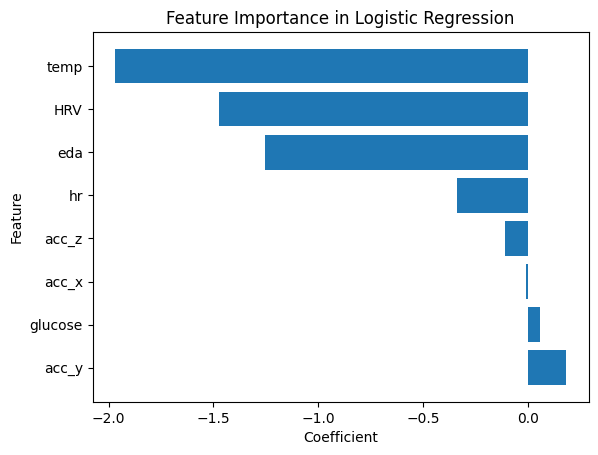

In [256]:
# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": logistic_model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

# Visualize feature importance
plt.barh(feature_importance["Feature"], feature_importance["Coefficient"])
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Feature Importance in Logistic Regression")
plt.show()

In [257]:
# Predict probabilities
y_test_probs = logistic_model.predict_proba(X_test)[:, 1]

# Adjust threshold
threshold = 0.6  # Default is 0.5
y_test_pred_adjusted = (y_test_probs >= threshold).astype(int)

# Evaluate with adjusted threshold
print(classification_report(y_test, y_test_pred_adjusted, target_names=["Normal GV", "High GV"]))


              precision    recall  f1-score   support

   Normal GV       1.00      0.97      0.99       380
     High GV       0.97      1.00      0.99       354

    accuracy                           0.99       734
   macro avg       0.99      0.99      0.99       734
weighted avg       0.99      0.99      0.99       734



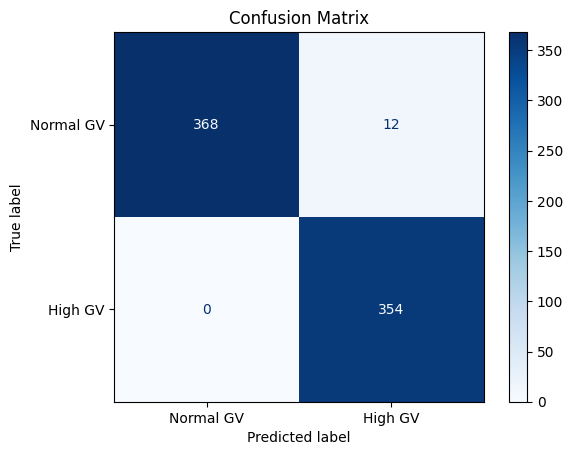

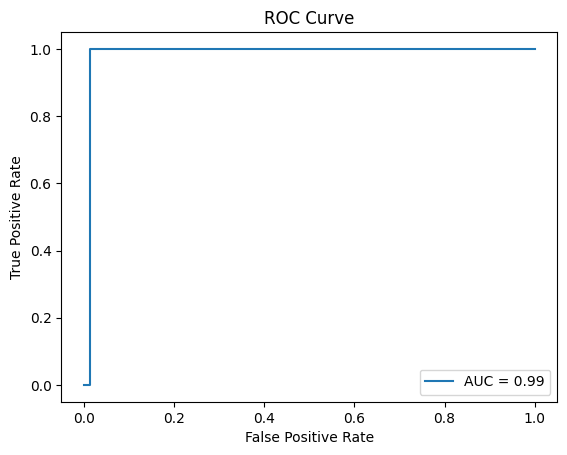

In [258]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal GV", "High GV"]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
auc = roc_auc_score(y_test, y_test_probs)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
